In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


Example 1 - Image shape: (256, 256, 3)
Example 1 - Label =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Example 1 - Mask shape: (256, 256, 1)


Example 2 - Image shape: (256, 256, 3)
Example 2 - Label =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Example 2 - Mask shape: (256, 256, 1)




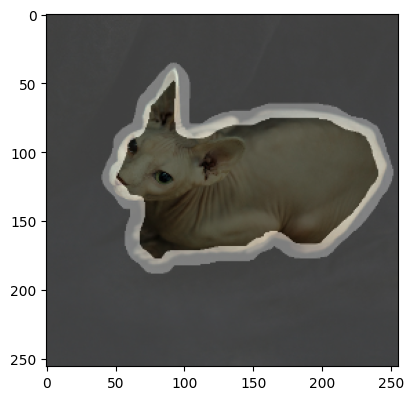

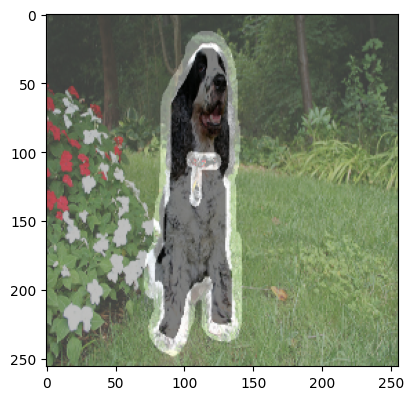

In [2]:
from data_loading import OxfordPetDataset
from augmentation import random_flip, augmentation_layers_geometric, augmentation_layers_color
from models import UNet_model #2.a, 2.b exercises
from experiment import plot_results

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

print("\n")

for i, example in enumerate(train.take(2)):  # Take two examples
    print(f"Example {i+1} - Image shape:", example['image'].shape)
    image = example['image']
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    label = example['label']
    print(f"Example {i+1} - Label = ", label.numpy())
    mask = example['segmentation_mask']  # This is the segmentation mask
    plt.imshow(mask, cmap='gray', alpha=0.5)
    print(f"Example {i+1} - Mask shape:", mask.numpy().shape)
    print("\n")
plt.show()

In [3]:
train

<_MapDataset element_spec={'image': TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(37,), dtype=tf.float32, name=None), 'segmentation_mask': TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)}>

In [4]:
augmentation_color = augmentation_layers_color()
augmentation_geometric = augmentation_layers_geometric()

tf.Tensor(
[[[0.32705036 0.23075514 0.1042356 ]
  [0.32658547 0.22854626 0.1108992 ]
  [0.32977575 0.23173654 0.11016792]
  ...
  [0.4634071  0.4426197  0.4257539 ]
  [0.45410472 0.4249687  0.38406798]
  [0.44884878 0.42139778 0.39002523]]

 [[0.32707566 0.22819327 0.11194919]
  [0.32426274 0.22521447 0.11059456]
  [0.3318321  0.23379289 0.11222427]
  ...
  [0.45989254 0.43244156 0.40891215]
  [0.4560049  0.42610863 0.38672838]
  [0.45368543 0.42623445 0.3948619 ]]

 [[0.32936618 0.23086338 0.11460703]
  [0.32843903 0.22984506 0.11386228]
  [0.33114097 0.23310176 0.11153313]
  ...
  [0.45975977 0.4323088  0.4028817 ]
  [0.4560049  0.42518383 0.38765317]
  [0.45485163 0.42740065 0.3960281 ]]

 ...

 [[0.7623767  0.776378   0.7634877 ]
  [0.76289064 0.7687883  0.76246935]
  [0.756653   0.7641238  0.7489842 ]
  ...
  [0.57483214 0.50922245 0.43810573]
  [0.6068628  0.53502065 0.44806117]
  [0.57956237 0.51383746 0.43652835]]

 [[0.76388067 0.7767553  0.77005535]
  [0.7679917  0.7679917  0

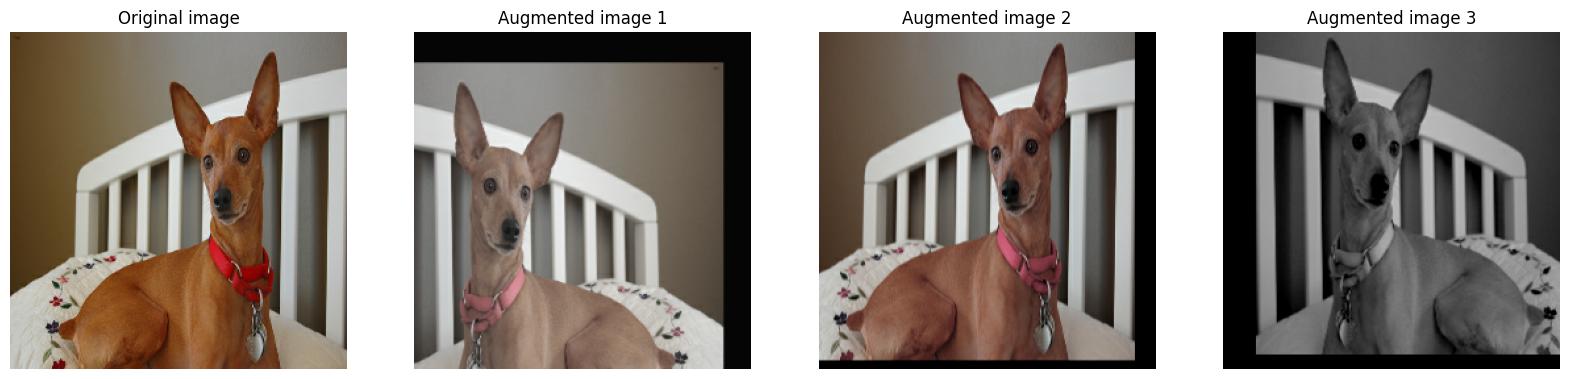

In [5]:
for example in train.take(1):
    image = example['image']
    print(image)
    
    plt.figure(figsize=(20, 5))
    
    # Plot original image
    plt.subplot(1, 4, 1)
    plt.title("Original image")
    plt.imshow(image)
    plt.axis("off")
    
    # Plot augmented images
    for i in range(3):
        aug_img = augmentation_geometric(tf.expand_dims(image, axis=0))
        aug_img = augmentation_color(aug_img)
        plt.subplot(1, 4, i+2)
        plt.title(f"Augmented image {i+1}")
        plt.imshow(aug_img[0])
        plt.axis("off")

plt.show()

From now on we want all datasets to be lists of just images and masks

In [6]:
def extract_image_mask(data):
    """Extract image and mask from dictionary"""
    print(data)
    return data['image'], data['image']

# Apply to all datasets
train = train.map(extract_image_mask)
val = val.map(extract_image_mask)
test = test.map(extract_image_mask)



{'image': <tf.Tensor 'args_0:0' shape=(256, 256, 3) dtype=float32>, 'label': <tf.Tensor 'args_1:0' shape=(37,) dtype=float32>, 'segmentation_mask': <tf.Tensor 'args_2:0' shape=(256, 256, 1) dtype=float32>}
{'image': <tf.Tensor 'args_0:0' shape=(256, 256, 3) dtype=float32>, 'label': <tf.Tensor 'args_1:0' shape=(37,) dtype=float32>, 'segmentation_mask': <tf.Tensor 'args_2:0' shape=(256, 256, 1) dtype=float32>}
{'image': <tf.Tensor 'args_0:0' shape=(256, 256, 3) dtype=float32>, 'label': <tf.Tensor 'args_1:0' shape=(37,) dtype=float32>, 'segmentation_mask': <tf.Tensor 'args_2:0' shape=(256, 256, 1) dtype=float32>}


In [7]:
def augment_image_mask(image, mask):
    # Add batch dimension (from (H,W,C) to (1,H,W,C)
    batched_image = tf.expand_dims(image, axis=0)
    batched_mask = tf.expand_dims(mask, axis=0)
    
    # Apply color augmentation to image only
    aug_image = augmentation_color(batched_image, training=True)
    
    # Combine image+mask for geometric augmentations
    combined = tf.concat([aug_image, batched_mask], axis=-1)
    combined = augmentation_geometric(combined, training=True)
    
    # Split back and remove batch dimension
    aug_image, aug_mask = tf.split(combined, [3, tf.shape(batched_mask)[-1]], axis=-1)
    return tf.squeeze(aug_image, axis=0), tf.squeeze(aug_mask, axis=0)

# Apply augmentations to training data only
train = train.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

task 2b)

In [10]:
BATCH_SIZE = 16

# Batch the data and use prefetching to optimize loading speed
train_ds = train.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
print(len(train_ds))

207


üöÄ Training Autoencoder on `train_ds` with Validation Data...
207/207 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 742s 3s/step - accuracy: 0.5273 - loss: 0.0292 - val_accuracy: 0.5851 - val_loss: 0.0302


‚úÖ Models and weights saved successfully!


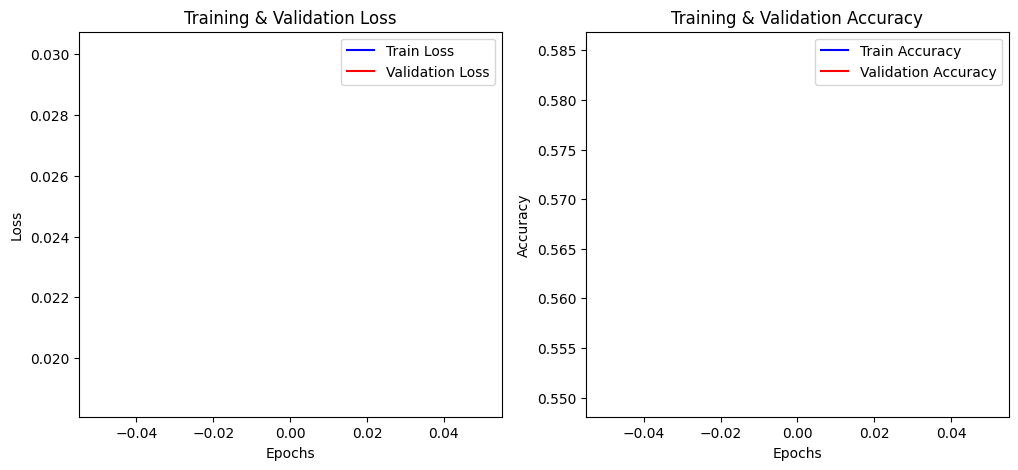

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from models import build_autoencoder, build_encoder_model  # ‚úÖ Import models

autoencoder = build_autoencoder()  # ‚úÖ Load Autoencoder

# ‚úÖ Compile Autoencoder
autoencoder.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

# ---------------------------- #
# ‚úÖ Train Autoencoder with Validation
# ---------------------------- #
print("üöÄ Training Autoencoder on `train_ds` with Validation Data...")
history = autoencoder.fit(
    train_ds,
    epochs=1,
    verbose=1,
    validation_data=val_ds  # ‚úÖ Provide validation dataset
)

# ---------------------------- #
# ‚úÖ Save Autoencoder & Encoder Models & Weights
# ---------------------------- #
autoencoder.save_weights("autoencoder.weights.h5")
autoencoder.save("autoencoder_model.h5")  # ‚úÖ Save Full Model


print("‚úÖ Models and weights saved successfully!")

# ---------------------------- #
# ‚úÖ Plot Training & Validation Accuracy & Loss
# ---------------------------- #
plt.figure(figsize=(12, 5))

# ‚úÖ Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

# ‚úÖ Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")

plt.show()


‚úÖ Model Loaded Successfully!
(<tf.Tensor: shape=(16, 256, 256, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 3.51263303e-03, 0.00000000e+00],
         [0.00000000e+00, 7.51929183e-04, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.60366890e-05, 6.03625737e-03, 3.76036391e-03],
         [4.93128179e-03, 1.30554195e-02, 5.69458026e-03],
         [1.22680666e-03, 6.42783986e-03, 4.93128179e-03]],

        [[0.00000000e+00, 0.00000000e+00, 6.28063735e-03],
         [0.00000000e+00, 1.00708008e-03, 0.00000000e+00],
         [0.00000000e+00, 3.91283212e-03, 0.00000000e+00],
         ...,
         [7.30255712e-03, 5.92400029e-05, 2.40550326e-05],
         [9.62356851e-03, 1.10976277e-02, 5.48011949e-03],
         [3.13158217e-03, 1.00708008e-03, 8.91113305e-04]],

        [[0.00000000e+00, 0.00000000e+00, 4.80861310e-03],
         [0.00000000e+00, 2.34375009e-03, 0.00000000e+00],
         [8.08715820e-02, 8.77838731e-02, 7.9132080

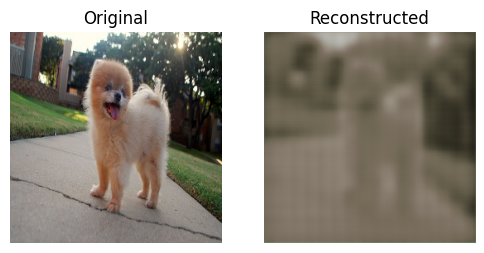

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# ---------------------------- #
# ‚úÖ Load the Trained Autoencoder
# ---------------------------- #
autoencoder_model = load_model("autoencoder.weights.h5", compile=False)
print("‚úÖ Model Loaded Successfully!")

# ---------------------------- #
# ‚úÖ Extract a Batch from `test_ds`
# ---------------------------- #
test_batch = next(iter(test_ds))  # ‚úÖ Get one batch (batch_size, 256, 256, 3)
test_images = test_batch[0].numpy()  # ‚úÖ Convert to NumPy array
print(test_batch)
print(test_images.shape)
# # ---------------------------- #
# # ‚úÖ Select a Random Image from the Batch
# # ---------------------------- #
import random
random_idx = random.randint(0, test_images.shape[0] - 1)  # Pick a random index
print(random_idx)
test_img = np.expand_dims(test_images[random_idx], axis=0)  # ‚úÖ Add batch dimension

# # ---------------------------- #
# # ‚úÖ Predict the Reconstructed Image
# # ---------------------------- #
pred = autoencoder_model.predict(test_img)

# # ---------------------------- #
# # ‚úÖ Plot Original vs Reconstructed Image
# # ---------------------------- #
plt.figure(figsize=(6,3))

# # Original Image
plt.subplot(1, 2, 1)
plt.imshow(test_img[0])  # Remove batch dimension
plt.title('Original')
plt.axis("off")

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(pred[0])  # Remove batch dimension
plt.title('Reconstructed')
plt.axis("off")

plt.show()


In [17]:
# Extract weights only for the encoder part of the Autoencoder. 
from tensorflow.keras.layers import  Input
from keras.models import Model
from models import  build_encoder   # ‚úÖ Import from models.py
autoencoder_model = load_model("autoencoder_model.h5", compile=False)
       
#Now define encoder model only, without the decoder part. 
input_shape = (256, 256, 3)
input_img = Input(shape=input_shape)

encoder = build_encoder(input_img)
encoder_model = Model(input_img, encoder)
print(encoder_model.summary())

num_encoder_layers = len(encoder_model.layers) #35 layers in our encoder. 
print(num_encoder_layers)

Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_7 (InputLayer)      ‚îÇ (None, 256, 256, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_97 (Conv2D)              ‚îÇ (None, 256, 256, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_94          ‚îÇ (None, 256, 256, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_94 (Activation)      ‚îÇ (None, 256, 256, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_98 (Conv2D)              ‚îÇ (None, 256, 256, 32)   ‚îÇ         9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_95          ‚îÇ (None, 256, 256, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_95 (Activation)      ‚îÇ (None, 256, 256, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_28 (MaxPooling2D) ‚îÇ (None, 128, 128, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_99 (Conv2D)              ‚îÇ (None, 128, 128, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_96          ‚îÇ (None, 128, 128, 64)   ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_96 (Activation)      ‚îÇ (None, 128, 128, 64)  

 Total params: 4,720,160 (18.01 MB)

 Trainable params: 4,716,192 (17.99 MB)

 Non-trainable params: 3,968 (15.50 KB)

None
35


In [15]:
#Get weights for the 35 layers from trained autoencoder model and assign to our new encoder model 
for l1, l2 in zip(encoder_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())

#Verify if the weights are the same between autoencoder and encoder only models. 
autoencoder_weights = autoencoder_model.get_weights()[0][1]
encoder_weights = encoder_model.get_weights()[0][1]

#Save encoder weights for future comparison
np.save('pretrained_encoder-weights.npy', encoder_weights )


In [16]:
test_batch = next(iter(test_ds))  # ‚úÖ Get one batch (batch_size, 256, 256, 3)
test_images = test_batch[0].numpy()  # ‚úÖ Convert to NumPy array
print(test_batch)
print(test_images.shape)
# # ---------------------------- #
# # ‚úÖ Select a Random Image from the Batch
# # ---------------------------- #
import random
random_idx = random.randint(0, test_images.shape[0] - 1)  # Pick a random index
print(random_idx)
test_img = np.expand_dims(test_images[random_idx], axis=0)  # ‚úÖ Add batch dimension

# # ---------------------------- #
# # ‚úÖ Predict the Reconstructed Image
# # # ---------------------------- #
# pred = autoencoder_model.predict(test_img)
temp_img_encoded=encoder_model.predict(test_img)
print(temp_img_encoded.shape)

(<tf.Tensor: shape=(16, 256, 256, 3), dtype=float32, numpy=
array([[[[6.22509718e-01, 6.27273500e-01, 6.38731837e-01],
         [6.69352472e-01, 6.63160026e-01, 6.54221594e-01],
         [7.09112763e-01, 7.13396132e-01, 7.15731144e-01],
         ...,
         [6.94959819e-01, 6.57191753e-01, 6.91309988e-01],
         [6.62272871e-01, 6.68896198e-01, 6.50377274e-01],
         [6.33877814e-01, 6.81710243e-01, 6.18906200e-01]],

        [[6.42785609e-01, 6.78421319e-01, 6.74271703e-01],
         [6.42997622e-01, 6.61031127e-01, 6.53157592e-01],
         [7.04683065e-01, 7.13299930e-01, 7.01943338e-01],
         ...,
         [6.74037158e-01, 6.55112028e-01, 6.71548963e-01],
         [6.09480500e-01, 6.14271522e-01, 6.13019109e-01],
         [5.55791736e-01, 5.93644738e-01, 5.53056061e-01]],

        [[6.42308593e-01, 7.05576360e-01, 6.70154572e-01],
         [6.34545624e-01, 7.02755153e-01, 6.62197948e-01],
         [6.60502732e-01, 7.10765600e-01, 6.61734700e-01],
         ...,
         

In [18]:
#Now let us define a Unet with same encoder part as out autoencoder. 
#Then load weights from the original autoencoder for the first 35 layers (encoder)
from models import build_unet


input_shape = (256, 256, 3)
unet_model = build_unet(input_shape)

#Print layer names for each model to verify the layers....
#First 35 layers should be the same in both models. 
unet_layer_names=[]
for layer in unet_model.layers:
    unet_layer_names.append(layer.name)

autoencoder_layer_names = []
for layer in autoencoder_model.layers:
    autoencoder_layer_names.append(layer.name)
    
#Make sure the first 35 layers are the same. Remember that the exct names of the layers will be different.
###########

#Set weights to encoder part of the U-net (first 35 layers)
for l1, l2 in zip(unet_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())


# unet_model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()
print(unet_model.output_shape)

unet_model.save('unet_model_weights.h5')

Model: "U-Net"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_8       ‚îÇ (None, 256, 256,  ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ 3)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_107 (Conv2D) ‚îÇ (None, 256, 256,  ‚îÇ        896 ‚îÇ input_layer_8[0]‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 256, 256,  ‚îÇ        128 ‚îÇ conv2d_107[0][0]  ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_104      ‚îÇ (None, 256, 256,  ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (Activation)        ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_108 (Conv2D) ‚îÇ (None, 256, 256,  ‚îÇ      9,248 ‚îÇ activation_104[0‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 256, 256,  ‚îÇ        128 ‚îÇ conv2d_108[0][0]  ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_105      ‚îÇ (None, 256, 256,  ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (Activation)        ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_32    ‚îÇ (None, 128, 128,  ‚îÇ          0 ‚îÇ activation_105[0‚Ä¶ ‚îÇ
‚îÇ (MaxPooling2D)      ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_109 (Conv2D) ‚îÇ (None, 128, 128,  ‚îÇ     18,496 ‚îÇ max_pooling2d_32‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

(None, 256, 256, 1)
